In [1]:
# !pip install pillow
# !pip install matplotlib
# !pip install spectral


In [2]:
import os
import spectral

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


In [3]:
def split_and_display_image(image_path):
    # 이미지 열기
    img = Image.open(image_path)

    # 원본 이미지 크기
    width, height = img.size

    # 3x2로 나누기 위해 각 조각의 크기 계산
    piece_width = (width // 3) * 0.9
    piece_height = height // 2

    # 잘라낸 이미지 저장할 리스트
    pieces = []

    # 이미지를 3x2로 나누기
    for row in range(2):  # 2행
        for col in range(3):  # 3열
            left = col * piece_width
            upper = row * piece_height
            right = (col + 1) * piece_width
            lower = (row + 1) * piece_height

            # 이미지 조각 잘라내기
            piece = img.crop((left, upper, right, lower))
            pieces.append(piece)

    # 조각들을 matplotlib으로 출력
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))  # 2행 3열 서브플롯
    for i, ax in enumerate(axes.flat):
        ax.imshow(pieces[i])
        ax.axis('off')  # 축 표시 제거

    plt.tight_layout()
    plt.show()



In [11]:
def display_hyperspectral_band(hdr_path, raw_path, wavelength):
    # Hyperspectral 이미지를 읽기
    img = spectral.open_image(hdr_path)

    # 특정 파장에 가까운 밴드 찾기
    wavelengths = img.metadata['wavelength']
    wavelengths = [float(w) for w in wavelengths]

    # 특정 파장에 가장 가까운 인덱스 찾기
    band_index = min(range(len(wavelengths)), key=lambda i: abs(wavelengths[i] - wavelength))

    # 해당 밴드 데이터 추출
    band_data = img.read_band(band_index)

    # 이미지 출력
    plt.figure(figsize=(8, 6))
    plt.imshow(band_data, cmap='gray')
    plt.title(f'Band at {wavelengths[band_index]} nm')
    plt.colorbar(label='Pixel Intensity')
    plt.axis('off')
    plt.show()

    print(img.shape)

In [5]:
def split_hyperspectral_cube(hdr_path, raw_path, output_dir):
    print(hdr_path)
    print(raw_path)
    # Hyperspectral 이미지를 읽기
    img = spectral.open_image(hdr_path)
    cube = img.load()

    # 원본 데이터 크기
    height, width, bands = cube.shape

    # 3x2로 나누기 위해 각 조각의 크기 계산
    piece_width = (width // 3) * 0.9
    piece_height = height // 2

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 6개의 조각으로 분할하여 저장
    cnt = 1
    for row in range(2):
        for col in range(3):
            # 파일명 생성
            file_name = (hdr_path.split("/")[-1])[:-4]

            # 조각의 범위 계산
            start_row = int(row * piece_height)
            end_row = int((row + 1) * piece_height)
            start_col = int(col * piece_width)
            end_col = int((col + 1) * piece_width)

            # 조각 데이터 추출
            piece_cube = cube[start_row:end_row, start_col:end_col, :]

            # HDR 및 RAW 파일 저장
            piece_hdr_path = os.path.join(output_dir, f"{file_name}_{cnt}.hdr")
            piece_raw_path = os.path.join(output_dir, f"{file_name}_{cnt}.raw")
            print(piece_hdr_path)

            # HDR 파일 생성
            metadata = img.metadata.copy()
            metadata['lines'] = piece_cube.shape[0]
            metadata['samples'] = piece_cube.shape[1]
            spectral.envi.save_image(piece_hdr_path, piece_cube, metadata=metadata, interleave='bip', force=True)

            # RAW 파일 저장
            piece_cube.tofile(piece_raw_path)

            # PNG 파일 저장 (100, 150, 200 밴드 활용 RGB 이미지)
            piece_png_path = os.path.join(output_dir, f"{file_name}_{cnt}.png")
            rgb_image = np.stack([piece_cube[:, :, 100].squeeze(), 
                                  piece_cube[:, :, 150].squeeze(), 
                                  piece_cube[:, :, 200].squeeze()], axis=2)
            rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image)) * 255  # Normalize to [0, 255]
            rgb_image = rgb_image.astype(np.uint8)  # Convert to uint8
            plt.imsave(piece_png_path, rgb_image)

            # plt.imshow(piece_cube[:, :, 100])
            # plt.show()
            # plt.imshow(piece_cube[:, :, 150])
            # plt.show()
            # plt.imshow(piece_cube[:, :, 200])
            # plt.show()
            # plt.imshow(rgb_image)
            # plt.show()
            
            # .img 파일 삭제
            piece_img_path = piece_hdr_path.replace('.hdr', '.img')
            if os.path.exists(piece_img_path):
                os.remove(piece_img_path)
            cnt += 1

    print(f"Split and saved 6 pieces to directory: {output_dir}")


In [9]:
# 데이터 폴더 전체를 순회하며 HDR 파일을 처리
input_dir = r"C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/data"
output_dir = r"C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/splited"

# HDR 파일 리스트 생성
hdr_files = []
for f in os.listdir(input_dir):
    if f.endswith('.hdr'):
        full_path = f"{input_dir}/{f}"
        hdr_files.append(full_path)

# HDR 파일 순회 처리
for hdr_path in hdr_files:
    raw_path = hdr_path.replace('.hdr', '.raw')  # 대응되는 RAW 파일 경로

    # # 분할 후 저장해야 할 경우 아래 한 줄 주석 해제
    # split_hyperspectral_cube(hdr_path, raw_path, output_dir) 


C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/data/Hsi20241205152845_0139.hdr
C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/data/Hsi20241205152845_0139.raw
C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/splited\Hsi20241205152845_0139_1.hdr


c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/splited\Hsi20241205152845_0139_2.hdr
C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/splited\Hsi20241205152845_0139_3.hdr
C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/splited\Hsi20241205152845_0139_4.hdr
C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/splited\Hsi20241205152845_0139_5.hdr
C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/splited\Hsi20241205152845_0139_6.hdr


KeyboardInterrupt: 

c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


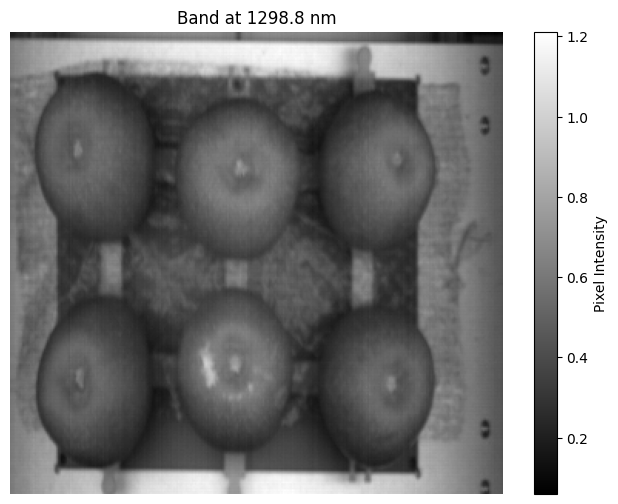

(300, 320, 256)


In [12]:
# # hdr 및 raw 파일 경로와 원하는 파장 입력
# hdr_path = r"C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/data/Hsi20241206162937_0276.hdr"  # HDR 파일 경로
# raw_path = r"C:/Users/Jaehyuk/Desktop/2024 자체 구축 데이터셋/사과/241205 사과 당도/data/Hsi20241206162937_0276.raw"  # RAW 파일 경로
# wavelength = 1300  # 원하는 파장 (nm)

# display_hyperspectral_band(hdr_path, raw_path, wavelength)
